<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/notebooks-readme/notebooks/community-distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Show:
- Narrow thing: How to make infections, ratio, and deaths predictions on Metaculus more consistent with each other
- Broad thing: Workflow that connects judgmental and model-based forecasting

In [0]:
import ergo

Log into Metaculus:

In [0]:
metaculus = ergo.Metaculus(username="ought", password="")

Retrieve the questions we want to model, using IDs from URLs:

In [0]:
q_infections = metaculus.get_question(3529, name="infections")
q_deaths = metaculus.get_question(3530, name="deaths")
q_ratio = metaculus.get_question(3755, name="ratio")

ergo.MetaculusQuestion.to_dataframe([q_infections, q_deaths, q_ratio])

,id,name,title,resolve_time
0,3529,infections,How many infections of COVID-19 will be estima...,2021-01-01 00:00:00+00:00
1,3530,deaths,How many people will die as a result of the 20...,2021-01-01 00:00:00+00:00
2,3755,ratio,What will be the ratio of fatalities to total ...,2021-01-01 05:00:00+00:00


Build a model that relates the questions:

In [0]:
def deaths_from_infections():
  infections = q_infections.sample_community()
  ratio = q_ratio.sample_community()
  deaths = infections * ratio
  ergo.tag(deaths, "deaths")
  return deaths

samples = ergo.run(deaths_from_infections, num_samples=5000)

samples

100%|██████████| 5000/5000 [00:02<00:00, 2326.42it/s]


,infections,ratio,deaths
0,3.219898e+08,0.011343,3.652317e+06
1,4.159977e+05,0.013316,5.539479e+03
2,4.119393e+08,0.013625,5.612568e+06
3,5.463975e+07,0.039994,2.185238e+06
4,2.741159e+07,0.002618,7.175377e+04
...,...,...,...
4995,8.211210e+08,0.015633,1.283622e+07
4996,1.129191e+07,0.002444,2.759480e+04
4997,1.375182e+07,0.005575,7.667059e+04
4998,1.144145e+08,0.010835,1.239672e+06


Compare with the community prediction for the deaths question:

100%|██████████| 5000/5000 [00:01<00:00, 4921.27it/s]


[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Log deaths')]

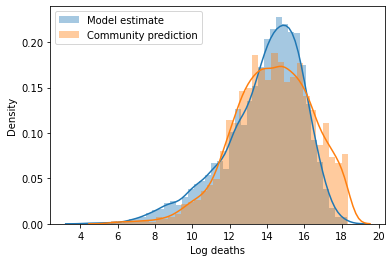

In [0]:
import seaborn
import numpy as np
import matplotlib.pyplot as plt

ax = seaborn.distplot(np.log(samples["deaths"]), label="Model estimate") # log deaths, estimated 
seaborn.distplot(np.log(ergo.run(q_deaths.sample_community)), label="Community prediction")
plt.legend()
ax.set(xlabel='Log deaths', ylabel='Density')

Mostly defer to community's estimates of death directly, but to the
extent that it's inconsistent with what community estimates for ratio
and infections imply, we want to update in that direction. so
mix our model estimate with community prediction for deaths:

In [0]:
def deaths_adjusted():
  if ergo.flip(.66):
    deaths = q_deaths.sample_community()
  else:
    deaths = deaths_from_infections()
  ergo.tag(deaths, "deaths_adjusted")

samples = ergo.run(deaths_adjusted, num_samples=5000)

seaborn.distplot(np.log(samples["deaths_adjusted"]))

Submit new distribution on deaths to Metaculus

In [0]:
q_deaths.submit_from_samples(samples)

**Exercise:** Apply the same idea to estimating infections from deaths